In [ ]:
%matplotlib inline
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
import os
from torch import optim
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
import matplotlib.pyplot as plt

SOS_token = 0
EOS_token = 1

hidden_size = 512  # LSTM hidden size
vocab_num = 28  # number of vocabulary:SOS, EOS, a-z
teacher_forcing_ratio = 0.8
LR = 0.05
epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class DataTransformer:
    def __init__(self):
        self.char2int = self.build_char2int()
        self.int2char = self.build_int2char()
        self.MAX_LENGTH = 0  # max length of the training data word (containing 'EOS')
    
    
    def build_char2int(self):
        dictionary = {'SOS':0, 'EOS':1}
        dictionary.update([(chr(i+97), i+2) for i in range(26)])
        return dictionary # {'SOS':0, 'EOS':1, 'a':2, 'b':3, ..., 'z':27}
    
    
    def build_int2char(self):
        dictionary = {0:'SOS', 1:'EOS'}
        dictionary.update([(i+2, chr(i+97)) for i in range(26)])
        return dictionary # {0:'SOS', 1:'EOS', 2:'a', 3:'b', ..., 27:'z'}
    
    # convert string(char sequence) to int sequence
    def chars2ints(self, chars):
        ints = []
        for c in chars:
            ints.append(self.char2int[c])
        ints.append(self.char2int['EOS'])
        
        self.MAX_LENGTH = max(self.MAX_LENGTH, len(ints))
        return ints
    
    # convert int sequence to string(char sequence)
    def ints2chars(self, ints):
        chars = ""
        for i in ints:
            chars += self.int2char[i]
        return chars

    def build_training_set(self, path):
        int_list = []  #[[wrong input,correct target], [wrong input,correct target], ...](input & target are all int sequence)
        str_list = []  #[[wrong input,correct target], [wrong input,correct target], ...](input & target are all string)
        
        with open(path, 'r') as file:
            dict_list = json.load(file)
            
            # 1 correct target might have multiple uncorrect input
            for dict in dict_list:
                target = self.chars2ints(dict['target']) # convert target string to int sequence
                for input in dict['input']:
                    int_list.append([self.chars2ints(input), target]) # convert input string to int sequence
                    str_list.append([input, dict['target']])

        return int_list, str_list

# Encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        # input_size: 28
        # hidden_size: 512
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden_state, cell_state):
        embedded = self.embedding(input).view(1, 1, -1)  # view(1,1,-1) due to input of rnn must be (seq_len,batch,vec_dim)
        output,(hidden_state, cell_state) = self.rnn(embedded, (hidden_state, cell_state))
        return output, hidden_state, cell_state
    
    # initialize hidden state
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    # initialize cell state
    def init_cell(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Decoder
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden_state, cell_state):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, (hidden_state, cell_state) = self.rnn(output, (hidden_state, cell_state))
        output = self.softmax(self.out(output[0]))
        return output, hidden_state, cell_state


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length, teacher_forcing_ratio):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    loss = 0

    # encoder forward
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device) # initialize
    encoder_hidden_state = encoder.init_hidden()
    encoder_cell_state = encoder.init_cell()
    
    for e_idx in range(input_length):
        encoder_output, encoder_hidden_state, encoder_cell_state = encoder(input_tensor[e_idx], encoder_hidden_state, encoder_cell_state)
        encoder_outputs[e_idx] = encoder_outputs[0,0]

    # decoder forward
    decoder_input = torch.tensor([[SOS_token]], device=device) # initialize
    decoder_hidden_state = encoder_hidden_state
    decoder_cell_state = encoder_cell_state

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # feed the target as the next input
        for d_idx in range(target_length):
            decoder_output,decoder_hidden_state,decoder_cell_state=decoder(decoder_input, decoder_hidden_state, decoder_cell_state)
            loss += criterion(decoder_output, target_tensor[d_idx])
            decoder_input = target_tensor[d_idx]  # don't care decoder_output is EOS or not

    else:
        # use its own predictions as the next input
        for d_idx in range(target_length):
            decoder_output, decoder_hidden_state, decoder_cell_state = decoder(decoder_input, decoder_hidden_state, decoder_cell_state)
            loss += criterion(decoder_output, target_tensor[d_idx])

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


def trainIters(encoder, decoder, training_pairs, learning_rate, max_length, teacher_forcing_ratio):
    # training_pairs: [(input, target), (input, target)....]
    loss_total=0
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    random.shuffle(training_pairs)  # shuffle training_pairs
    for input_tensor,target_tensor in training_pairs:
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length, teacher_forcing_ratio)
        loss_total += loss

    return loss_total / len(training_pairs)


# return predicted int sequence for one input_tensor
def predict_ints(input_tensor, encoder, decoder, max_length):
    predicted = []
    input_length = input_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)  # initialize encoder outputs
    
    # encoder forward
    encoder_hidden_state = encoder.init_hidden()
    encoder_cell_state = encoder.init_cell()
    for e_idx in range(input_length):
        encoder_output, encoder_hidden_state, encoder_cell_state = encoder(input_tensor[e_idx], encoder_hidden_state, encoder_cell_state)
        encoder_outputs[e_idx] = encoder_output[0,0]
    
    # decoder forward
    decoder_input=torch.tensor([[SOS_token]], device=device)
    decoder_hidden_state = encoder_hidden_state
    decoder_cell_state = encoder_cell_state
    for d_idx in range(max_length):
        decoder_output, decoder_hidden_state, decoder_cell_state = decoder(decoder_input,decoder_hidden_state,decoder_cell_state)
        topv, topi = decoder_output.data.topk(1) 
        decoder_input = topi.squeeze().detach()
        if decoder_input.item() == EOS_token:
            break
        else:
            predicted.append(decoder_input.item())
    return predicted


# return predicted int sequence list for whole testing set
def evaluateAll(encoder, decoder, testing_pairs, max_length):
    predicted_list=[]
    for input_tensor,target_tensor in testing_pairs:
        predicted_list.append(predict_ints(input_tensor, encoder, decoder, max_length))
    return predicted_list


# compute BLEU-4 score
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33, 0.33, 0.33)
    else:
        weights = (0.25, 0.25, 0.25, 0.25)
    return sentence_bleu([reference], output, weights=weights, smoothing_function=cc.method1)



epoch 1 loss:1.7335
BLEU-4: 0.22 


epoch 2 loss:1.3943
BLEU-4: 0.25 


epoch 3 loss:1.2608
BLEU-4: 0.35 


epoch 4 loss:1.1427
BLEU-4: 0.39 


epoch 5 loss:1.0158
BLEU-4: 0.51 


epoch 6 loss:0.9053
BLEU-4: 0.55 


epoch 7 loss:0.8261
BLEU-4: 0.55 


epoch 8 loss:0.7416
BLEU-4: 0.66 


epoch 9 loss:0.6600
BLEU-4: 0.66 


epoch10 loss:0.5869
BLEU-4: 0.71 


epoch11 loss:0.5352
BLEU-4: 0.68 


epoch12 loss:0.4857
BLEU-4: 0.77 


epoch13 loss:0.4247
BLEU-4: 0.86 


epoch14 loss:0.3861
BLEU-4: 0.85 


epoch15 loss:0.3412
BLEU-4: 0.85 


epoch16 loss:0.3242
BLEU-4: 0.82 


epoch17 loss:0.2887
BLEU-4: 0.85 


epoch18 loss:0.2591
BLEU-4: 0.84 


epoch19 loss:0.2242
BLEU-4: 0.86 


epoch20 loss:0.2008
BLEU-4: 0.94 


epoch21 loss:0.1932
BLEU-4: 0.90 


epoch22 loss:0.1636
BLEU-4: 0.90 


epoch23 loss:0.1483
BLEU-4: 0.88 


epoch24 loss:0.1400
BLEU-4: 0.94 


epoch25 loss:0.1395
BLEU-4: 0.96 


epoch26 loss:0.1242
BLEU-4: 0.93 


epoch27 loss:0.1148
BLEU-4: 0.94 


epoch28 loss:0.1074
BLEU-4: 

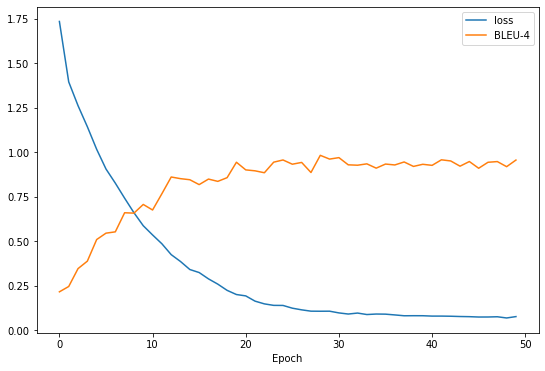

In [ ]:
# load training data
# training_list = [[wrong input,correct target], [wrong input,correct target], ...](input & target are all int sequence)
datatransformer = DataTransformer()
training_list, training_input = datatransformer.build_training_set(path = 'train.json')

# convert list to tensor
training_tensor_list = []
for training_pair in training_list:
    input_tensor = torch.tensor(training_pair[0], device = device).view(-1, 1) #(string_length x 1)
    target_tensor = torch.tensor(training_pair[1], device = device).view(-1, 1) #(string_length x 1)
    training_tensor_list.append((input_tensor, target_tensor))

# load testing data
# testing_list = [[wrong input,correct target], [wrong input,correct target], ...](input & target are all int sequence)
# testing_input = [[wrong input,correct target], [wrong input,correct target], ...](input & target are all string)
testing_list, testing_input = datatransformer.build_training_set(path = 'test.json')

# convert list to tensor
testing_tensor_list = []
for testing_pair in testing_list:
    input_tensor = torch.tensor(testing_pair[0], device = device).view(-1, 1) #(string_length x 1)
    target_tensor = torch.tensor(testing_pair[1], device = device).view(-1, 1) #(string_length x 1)
    testing_tensor_list.append((input_tensor, target_tensor))

# model
encoder = EncoderRNN(vocab_num, hidden_size).to(device)
decoder = DecoderRNN(vocab_num, hidden_size).to(device)

# train
loss_list = []
BLEU_list = []
best_score = 0
best_encoder_weights, best_decoder_weights = None, None

for epoch in range(1, epochs+1):
    loss = trainIters(encoder,decoder,training_tensor_list,learning_rate=LR,max_length=datatransformer.MAX_LENGTH,teacher_forcing_ratio=teacher_forcing_ratio)
    print(f'epoch{epoch:>2d} loss:{loss:.4f}')
    
    predicted_list = evaluateAll(encoder,decoder,testing_tensor_list,max_length=datatransformer.MAX_LENGTH)
    score = 0
    for i,(input,target) in enumerate(testing_input):
        predict = datatransformer.ints2chars(predicted_list[i])
        score += compute_bleu(predict, target)
    score /= len(testing_input)
    print(f'BLEU-4: {score:.2f}', "\n\n")

    loss_list.append(loss)
    BLEU_list.append(score)
    # update best model weights
    if score>best_score:
        best_score=score
        best_encoder_weights=copy.deepcopy(encoder.state_dict())
        best_decoder_weights=copy.deepcopy(decoder.state_dict())

# plot loss curve and bleu-4 curve
plt.figure(figsize = (9,6))
plt.xlabel("Epoch")
plt.plot(loss_list, label='loss')
plt.plot(BLEU_list,label='BLEU-4')
plt.legend()
plt.show()


In [ ]:
# output prediction of test.join
# load testing data
testing_list, testing_input = datatransformer.build_training_set(path = 'test.json')

# convert list to tensor
testing_tensor_list = []
for testing_pair in testing_list:
    input_tensor = torch.tensor(testing_pair[0], device = device).view(-1, 1) #(string_length x 1)
    target_tensor = torch.tensor(testing_pair[1], device = device).view(-1, 1) #(string_length x 1)
    testing_tensor_list.append((input_tensor, target_tensor))

# load the best weight for encoder and decoder
encoder.load_state_dict(best_encoder_weights)
decoder.load_state_dict(best_decoder_weights)

predicted_list=evaluateAll(encoder,decoder,testing_tensor_list,max_length=datatransformer.MAX_LENGTH)
score=0
print("For test.json: \n")
for i,(input,target) in enumerate(testing_input):
    predict=datatransformer.ints2chars(predicted_list[i])
    print('============================')
    print(f'input:  {input}')
    print(f'target: {target}')
    print(f'pred:   {predict}')
    score += compute_bleu(predict,target)
score /= len(testing_input)
print(f'BLEU-4: {score:.2f}')

For test.json: 

input:  contenpted
target: contented
pred:   contented
input:  begining
target: beginning
pred:   beginning
input:  problam
target: problem
pred:   problem
input:  dirven
target: driven
pred:   driven
input:  ecstacy
target: ecstasy
pred:   ecstasy
input:  juce
target: juice
pred:   juice
input:  localy
target: locally
pred:   locally
input:  compair
target: compare
pred:   compare
input:  pronounciation
target: pronunciation
pred:   pronunciation
input:  transportibility
target: transportability
pred:   transportability
input:  miniscule
target: minuscule
pred:   minuscule
input:  independant
target: independent
pred:   independent
input:  aranged
target: arranged
pred:   arranged
input:  poartry
target: poetry
pred:   portory
input:  leval
target: level
pred:   level
input:  basicaly
target: basically
pred:   basically
input:  triangulaur
target: triangular
pred:   triangular
input:  unexpcted
target: unexpected
pred:   unexpected
input:  stanerdizing
target: standar

In [ ]:
# output prediction of new_test.join
# load testing data
testing_list, testing_input = datatransformer.build_training_set(path = 'new_test.json')

# convert list to tensor
testing_tensor_list = []
for testing_pair in testing_list:
    input_tensor = torch.tensor(testing_pair[0], device = device).view(-1, 1) #(string_length x 1)
    target_tensor = torch.tensor(testing_pair[1], device = device).view(-1, 1) #(string_length x 1)
    testing_tensor_list.append((input_tensor, target_tensor))

# load the best weight for encoder and decoder
encoder.load_state_dict(best_encoder_weights)
decoder.load_state_dict(best_decoder_weights)

predicted_list=evaluateAll(encoder,decoder,testing_tensor_list,max_length=datatransformer.MAX_LENGTH)
score=0
print("For new_test.json: \n")
for i,(input,target) in enumerate(testing_input):
    predict=datatransformer.ints2chars(predicted_list[i])
    print('============================')
    print(f'input:  {input}')
    print(f'target: {target}')
    print(f'pred:   {predict}')
    score += compute_bleu(predict,target)
score /= len(testing_input)
print(f'BLEU-4: {score:.2f}')

For new_test.json: 

input:  apreciate
target: appreciate
pred:   appreciate
input:  appeciate
target: appreciate
pred:   appreciate
input:  apprciate
target: appreciate
pred:   appreciate
input:  apprecate
target: appreciate
pred:   appreciate
input:  apprecite
target: appreciate
pred:   appreciate
input:  luve
target: love
pred:   love
input:  culd
target: cold
pred:   clud
input:  heart
target: heart
pred:   heart
input:  televiseon
target: television
pred:   television
input:  thone
target: phone
pred:   phone
input:  phace
target: phase
pred:   phase
input:  poam
target: poem
pred:   poem
input:  tomorraw
target: tomorrow
pred:   tomorrow
input:  presishan
target: precision
pred:   presion
input:  presishion
target: precision
pred:   preision
input:  presisian
target: precision
pred:   perision
input:  presistion
target: precision
pred:   presition
input:  perver
target: prefer
pred:   pervior
input:  predgudice
target: prejudice
pred:   producdise
input:  predgudis
target: prejud

# Procedure
將 input 單字按照字母的順序轉成 2~27 的數字，再用 nn.embedding 轉成一個 512 維 embedding vector 丟進由 LSTM 組成的 encoder 和 decoder 去訓練。



# Result & Discussion
針對 teacher forcing ratio 去做比較 (30 epochs)：
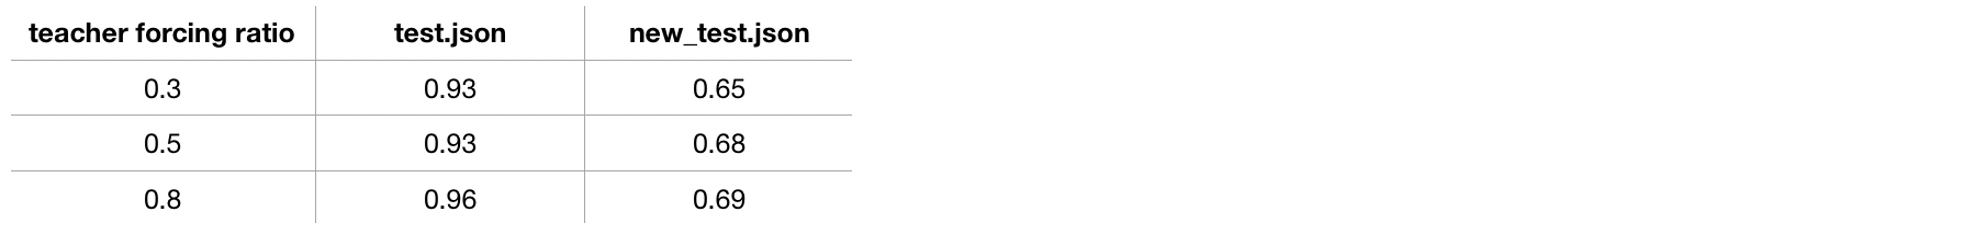

如果跑到 50 epochs，test.json 的 bleu-4 = 0.98，new_test.json 的 bleu-4 = 0.71